In [34]:
import numpy as np
import os
import json
from sklearn.model_selection import train_test_split
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn import metrics

In [52]:
def readData():
    dataFolder = "./data/"
    files = os.listdir(dataFolder)
    data = []
    a = []
    for file in files:
        path = dataFolder + file
        with open(path, "r") as f:
            raw = f.read()
            raw = raw.split("\n")
            for singleRaw in raw[:-1]:
                datapoint = json.loads(singleRaw)
                readings = datapoint["data"]
                hz = len(readings) / ((readings[-1][0] - readings[0][0]) * 10**-9)  # timestamp is in nanoseconds
                if (hz > 40):
                    data += [datapoint]
                else:
                    a.append(len(datapoint["data"]))
    print(a)

    return data

data = readData()

[233, 654, 389, 1191, 31, 415, 1051, 27, 199, 905, 25, 67, 34, 219, 581, 1563, 1331, 248, 363, 478, 624, 1723, 906, 33, 173, 1011, 637, 665, 648, 123, 332, 821, 1277, 1162, 30, 308, 319, 694, 390, 751, 366, 165, 799, 271, 453, 111, 260]


In [26]:
def normalise(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset-mu) / sigma

def convertData(data):
    X, T, truth, misc = [], [], [], []
    for d in data:
        id = d["id"]
        drunk = d["drunk"]
        walking = d["walking"]
        readings = d["data"]
        firstTimestamp = readings[0][0]
        convertedReadings = []
        timestamps = []
        for r in readings:
            t, x, y, z = r
            timestamp = t - firstTimestamp  # slide so all timestamps start at 0
            if timestamp < 30 * 10**9 and len(convertedReadings)<1200:
                convertedReadings += [ [x, y, z] ]
                timestamps += [t]
            if timestamp < 0:
                break
        else:
            if len(convertedReadings) == 1200:
                X += [normalise(np.array(convertedReadings))]
                T += [timestamps]
                truth += [drunk]
                misc += [id, walking]
    X = np.array(X)
    T = np.array(T)
    truth = np.array(truth).astype(int)
    misc = np.array(misc)
    return X, T, truth, misc



X, T, y, misc = convertData(data)

In [27]:
def prod(xs):
    t = 1
    for x in xs:
        t *= x
    return t

def svd (dataset):
    a, *b = dataset.shape
    twoD = dataset.reshape(a, prod(b))
    d = (twoD - twoD.mean(axis=0))
    u, ls, vh = np.linalg.svd(d, full_matrices=True)

    s = np.zeros((u.shape[0],2))
    np.fill_diagonal(s, ls)

    dataset_svd = np.dot(d, vh[:2].T)
    return dataset_svd

Z = svd(X)

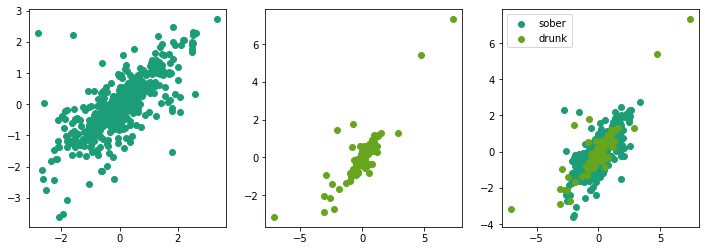

In [28]:
colourmap = plt.cm.Dark2

def displaydata(dataset, y):
    fig, axes = plt.subplots(ncols=3, figsize=(12,4))
    for i in range(2):
        thisX = X[y==i]
        axes[2].scatter(thisX[:,0], thisX[:,1], color=colourmap(1.*i/2), label="drunk" if i==1 else "sober")
        axes[i].scatter(thisX[:,0], thisX[:,1], color=colourmap(1.*i/2))
    axes[2].legend(loc="upper left")

displaydata(Z, y)

In [29]:
def getTrainTestSplit(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
    return X_train, X_test, y_train, y_test

Z_train, Z_test, y_train, y_test = getTrainTestSplit(Z, y)


In [41]:
clf = svm.SVC(kernel="rbf")
clf.fit(Z_train, y_train)

y_pred = clf.predict(Z)

In [48]:
accuracy = metrics.accuracy_score(y, y_pred)
precision = metrics.precision_score(y, y_pred)
recall = metrics.recall_score(y, y_pred)

print(f"accuracy:  {accuracy}")
print(f"precision: {precision}")
print(f"recall:    {recall}")

len(y[y==1])


accuracy:  0.8253275109170306
precision: 0.0
recall:    0.0


C:\Users\Nat\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


40